## Exploration of Dna2Vec embedding space for bacterial genomes; 10-mers

This notebook explores clusters formed by distributed represenation of genomic sequence based on word2vec algorithm. The representation is created from pre-trained 10-mer embedding. The embedding was trained on whole genome sequences of bacterial kingdom sampled from NCBI database in March of 2019. This embedding contains 1048576 kmers represented as 100 dimensional vectors. The embedding is created using [github reporsitory](https://github.com/pnpnpn/dna2vec) supplement of ["dna2vec: Consistent vector representations of variable-length k-mers"]( https://arxiv.org/abs/1701.06279) paper by Patric Ng. 

### Motivation for using bacteria k-mer embeddings for dpmitolin project

Dpmitolin project aims at development of a new method for building phylogenetic tree of human cells using mitochondria transcriptone data. Creation of phylogenetic tree is one of the central ideas of genomics. There are many reliable ways for creating phylogenetic trees using gene expression data. Current state of the art single cell genomic method uses [Seurat library](https://satijalab.org/seurat/install.html) by Satija Lab implemented in R. [MetaPalette method](https://msystems.asm.org/content/1/3/e00020-16) commonly used in metagenomics counts of k-mers length of 30 to 50 instead of gene expression. Long k-mers allow reliable identification of taxonomic relationships between newly discovered bacteria and detection of unknown species. Both of these techniques use data representation that do not capture local context surrounding a gene or k-mer.

Distributed representation of words in context using bag of words or skip-grams method introduced in [word2vec method](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) proved to be very useful in Natural Language Processing.  Dpmitolin project is currently operating under a hypothesis that longer k-mers (k 10 to 15) represented as word embeddings in context of other longer k-mers found within cell mitochondria might provide a good representation for creation of phylogenetic trees. The fact that mitachondria sequence is relatively short and contains fast and slow evolving parts might prove to be conducive to detecting closeness criteria for inferring child-parent relationships between individual cells. The fact that mitochondria is a bacteria living inside a cell justifies our current focus on models derived from bacterial kingdom. 

I also hope that long k-mer embeddings might become useful for multiple downstream NLP tasks that would mix data from genomic sequences represented by the embeddings pre-trained in the Dpmitolin project and clinical record data. These embeddings might be also useful for creation of models combining genomic data with information from news sources, geo and environment data sources etc. enabling exploration of a web of possible dependencies between human activity,environment and culture and information captures in genome.

### Faigen library

This notebook uses [Faigen library](https://github.com/sergeman/fastai-genomic) developed for the purpose of Dpmitolin project. Faigen library is name stands for "fast ai genomic". The library uses Fast.ai Databunch API and aims to be compatible with the fast.ai models, coding standards and software engineering abstractions. 







In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

from faigen.data import sequence
from faigen.data.sequence import regex_filter, count_filter
from functools import partial
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D

## Load embdding

In [4]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')  # C text fordmat

In [8]:
len(word_vectors.vocab)

1048576

### Visualisation of the embedding

#### Subsample embedding

In [4]:
from collections import Counter
def to_color(d):
    return 0. if "A" not in d.keys() else d["A"]/10.,   0. if "G" not in d.keys() else d["G"]/10., 0. if "C" not in d.keys() else d["C"]/10., 0.1 if "T" not in d.keys() else d["T"]/9.
kmers=list(word_vectors.wv.vocab.keys())[::100] #sample 1% of embedding content
X=word_vectors[kmers]
counts = [Counter(k) for k in kmers]
colors = [to_color(d) for d in counts]

#### Dimentionality reduction

In [5]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
%time X_tsne = tsne.fit_transform(X)

CPU times: user 9min 38s, sys: 578 ms, total: 9min 39s
Wall time: 9min 38s


#### Plot represenation in 3d

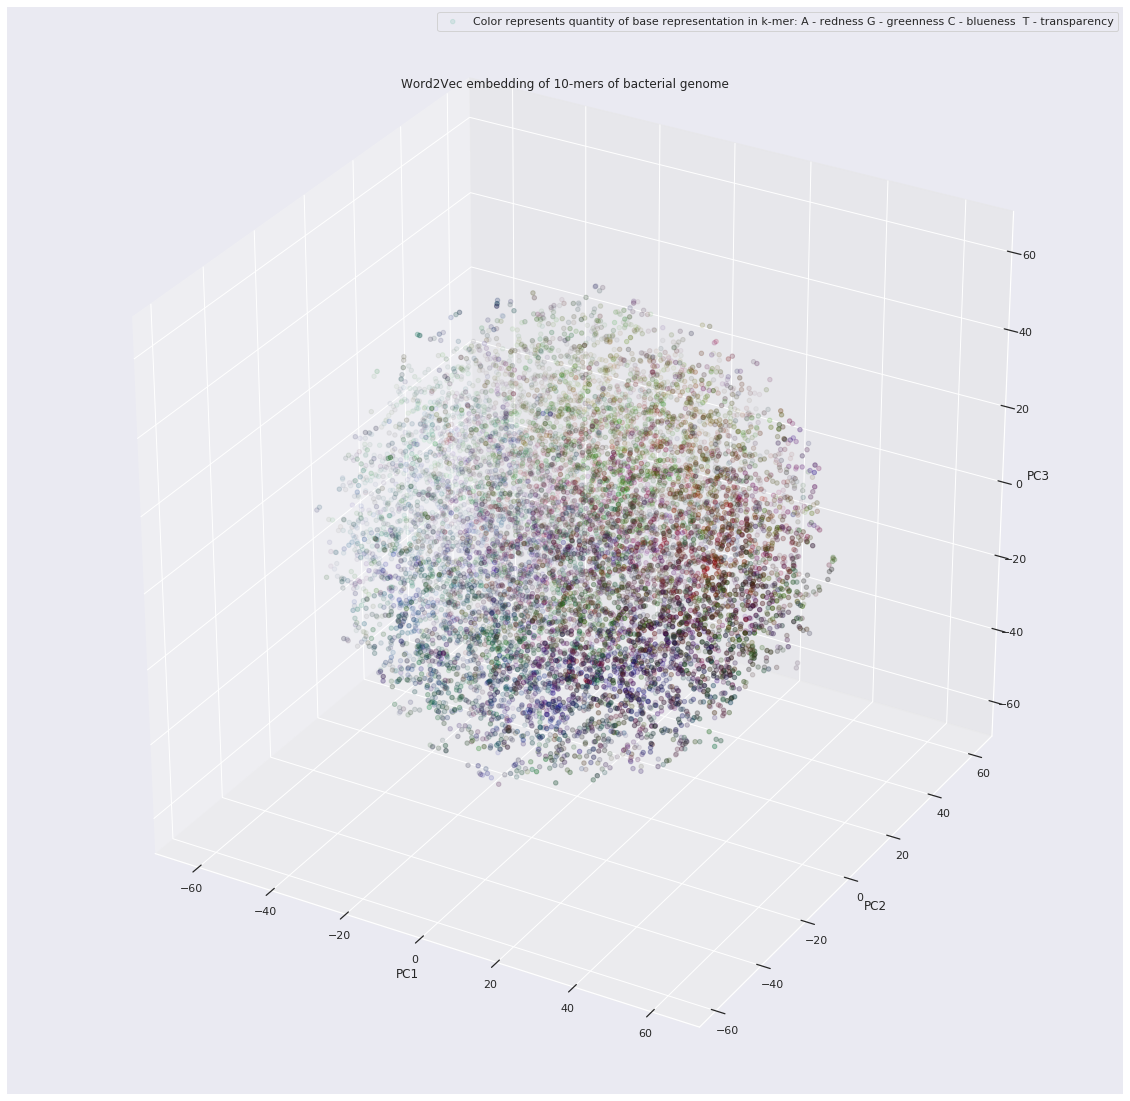

In [10]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_tsne[:,0],X_tsne[:,1],X_tsne[:,2],marker=".", c=colors,s=80)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("Word2Vec embedding of 10-mers of bacterial genome")
ax.legend(['Color represents quantity of base representation in k-mer: A - redness G - greenness C - blueness  T - transparency'])
plt.show()

##  Phylogenetic tree

### Load sequences for three bacteria genus

We are looking at Streptomyces, Streptococcus, and Staphylococcus genus
The phylogenetic tree represents hierarchical clustering of genome representation for different strains of bacteria within genus

During data loading process Faigen library creates Dna2Vec list containing distributed representation of entire genome as a 100 dimensional vector. The genome representation is computed as mean value of all k-mer embedding vectors found in the genome sequence

In [51]:
# rx_keep="Streptomyces|Bacillus|Vibrio|Streptococcus|Rhizobium|Staphylococcus"
rx_keep="Streptomyces|Streptococcus|Staphylococcus"

filters=[partial(regex_filter, rx=rx_keep),partial(regex_filter, rx="plasmid", keep=False)]
data = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas",filters=filters,n_cpus=7,emb=word_vectors, recurse=True)
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=10, skip=0, n_cpus=7)),
    sequence.Dna2VecProcessor(emb=word_vectors)]
for p in processors:
    print("\n", type(p))
    %time p.process(data)

 60%|██████    | 3/5 [00:00<00:00, 21.68it/s]


 <class 'faigen.data.sequence.GSFileProcessor'>


100%|██████████| 5/5 [00:00<00:00, 19.92it/s]

CPU times: user 242 ms, sys: 23.8 ms, total: 266 ms
Wall time: 264 ms

 <class 'faigen.data.sequence.GSTokenizeProcessor'>


CPU times: user 385 ms, sys: 268 ms, total: 654 ms
Wall time: 1.53 s

 <class 'faigen.data.sequence.Dna2VecProcessor'>
CPU times: user 17.5 s, sys: 4.06 s, total: 21.5 s
Wall time: 27.4 s


### Create clustering labels

In [13]:
def log_scale(X):
    x=np.asarray(X);e=1e-6
    return np.log10(x+np.abs(x.min())+e) 


x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1:3]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
y=labelList

X_df=pd.DataFrame(data=log_scale(X), index=labelList)

### Cluster genomes using cosign distance
cosign distance reflects semantic similarity of words in embedding

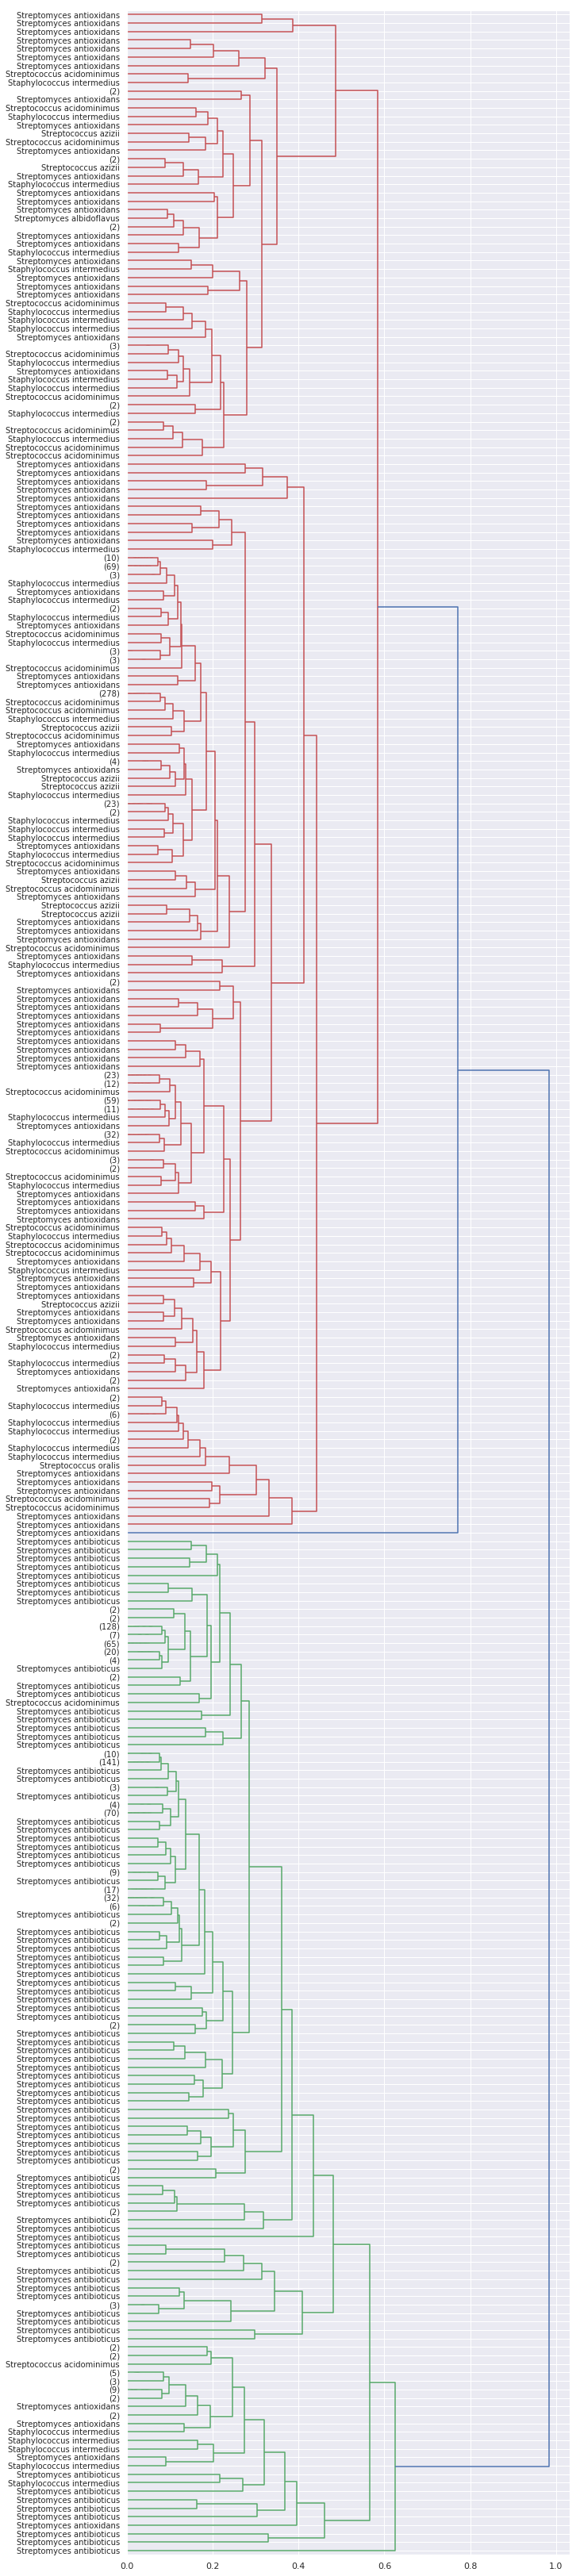

In [14]:
linked = linkage(X,method="complete", metric="cosine")

fig=plt.figure(figsize=(10, 59)) 
ax1 = fig.add_subplot(111)

htree = dendrogram(linked,  
            ax=ax1,
            orientation='right',
            p=300,
            truncate_mode='lastp',
            leaf_font_size = 10,
            labels=labelList,
            distance_sort='descending',
            show_contracted=True,       
            show_leaf_counts=True)

### K Nearest Neighbors Graph

In [58]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import time

def log_scale(X):
    x=np.asarray(X);e=1e-6
    return np.log10(x+np.abs(x.min())+e) 


x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1:3]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
y=labelList

X_df=pd.DataFrame(data=X, index=labelList).sort_index()

In [59]:
X_df.shape

(742, 100)

In [69]:
knn_graph = kneighbors_graph(X_df,100, include_self=False)

In [70]:
df=pd.DataFrame(data=knn_graph.toarray(),index=y, columns=y)

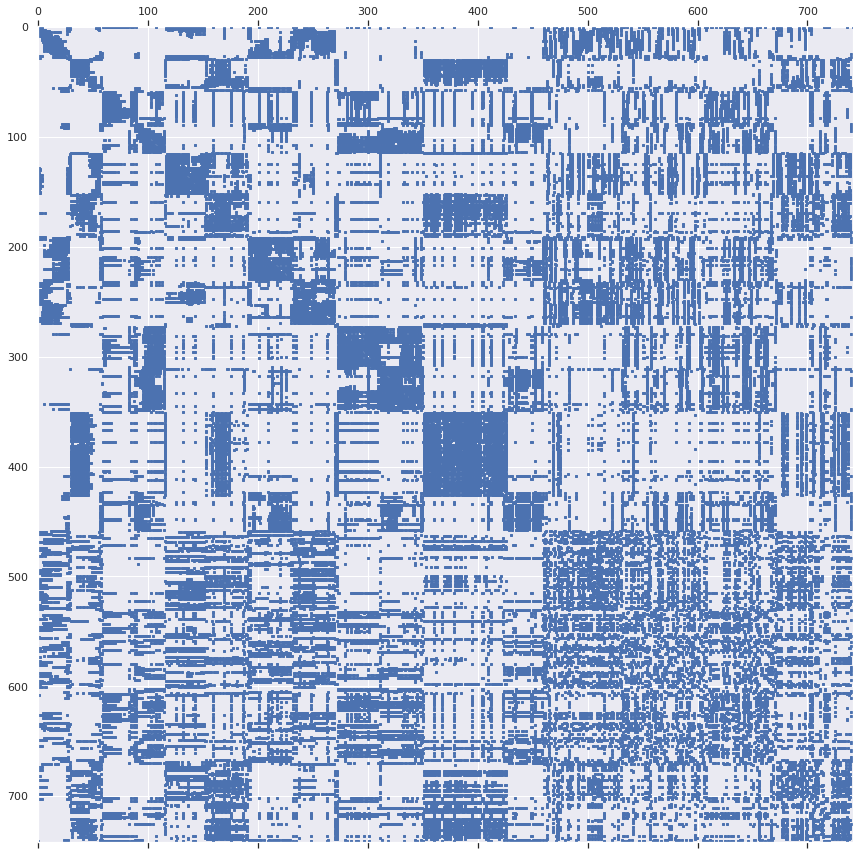

In [71]:
import scipy.sparse as sparse
fig= plt.figure(figsize=(15,15))
plt.spy(df,markersize=2)

### Explore embedding space of the genomes

We are looking at a larger group of genomes including 6 bacteria genus: 
- Streptomyces
- Bacillus
- Vibrio
- Streptococcus
- Rhizobium
- Staphylococcus

In [15]:
rx_keep="Streptomyces|Bacillus|Vibrio|Streptococcus|Rhizobium|Staphylococcus"

filters=[partial(regex_filter, rx=rx_keep),partial(regex_filter, rx="plasmid", keep=False)]
data = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas",filters=filters,n_cpus=7,emb=word_vectors, recurse=True)
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=10, skip=0, n_cpus=7)),
    sequence.Dna2VecProcessor(emb=word_vectors)]
for p in processors:
    print("\n", type(p))
    %time p.process(data)

  8%|▊         | 4/50 [00:00<00:01, 35.55it/s]


 <class 'faigen.data.sequence.GSFileProcessor'>


100%|██████████| 50/50 [00:01<00:00, 41.87it/s]

CPU times: user 1.13 s, sys: 80 ms, total: 1.21 s
Wall time: 1.21 s

 <class 'faigen.data.sequence.GSTokenizeProcessor'>


CPU times: user 2.13 s, sys: 1.05 s, total: 3.18 s
Wall time: 5.8 s

 <class 'faigen.data.sequence.Dna2VecProcessor'>
CPU times: user 23.8 s, sys: 5.52 s, total: 29.3 s
Wall time: 46.1 s


In [16]:
x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1:3]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
vocab=list(np.unique(labelList))
y=[vocab.index(x) for x in labelList]

In [18]:
tsne = manifold.TSNE(n_components=3, init='pca', perplexity=50, metric="correlation",random_state=0)
%time X3 = tsne.fit_transform(log_scale(X))

genus = [i.split()[0] for i in labelList]
genus_vocab=list(np.unique(genus))
y=[genus_vocab.index(x) for x in genus]
genus_vocab

X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2','pc3'], index=labelList)

X3_df["genus"]=genus
X3_df["y"]=y

genus_df=X3_df.groupby("genus").agg({"pc1": list, "pc2":list,"pc3":list,"y":np.mean})

CPU times: user 2min 29s, sys: 359 ms, total: 2min 29s
Wall time: 2min 28s


In [19]:
data=[]
for g in genus_df.index:
    trace  = go.Scatter3d(
        name = str(g),
        x=genus_df.loc[g,"pc1"],
        y=genus_df.loc[g,"pc2"],
        z=genus_df.loc[g,"pc3"],
        mode='markers',
        marker=dict(
            size=8,
            color=genus_df.loc[g,"y"],                # set color to an array/list of desired values
            colorscale='Jet',           # choose a colorscale
            opacity=0.5)
    )

    data.append(trace)
    

layout = go.Layout(
    width=1299,
    height=1299,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='correlation distance of 6 bacteria genus')

/home/serge/.local/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



If you do not see an interactive 3D chart above, [use this link to see it](https://plot.ly/~sergeman/20/bacillus-rhizobium-staphylococcus-streptococcus-streptomyces-vibrio/). You would need WebGL support in your browser for that.


## Genome Inventory of this notebook

In [20]:
all_fastas = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas", recurse=True ).descriptions
inventory = pd.DataFrame(data=[l.split()[1:3] for l in all_fastas], columns=["genus","species" ]).groupby(["genus", "species"]).agg({"species": "count"})
inventory.columns=["count"]
inventory

100%|██████████| 106/106 [00:02<00:00, 40.07it/s]


count
genus            species                      
Bacillus         andreraoultii,             58
                 cereus                      4
                 coahuilensis              138
                 eiseniae                    9
                 krulwichiae                 1
                 mannanilyticus            108
                 massilioanorexius         120
                 panaciterrae              189
                 psychrosaccharolyticus    265
                 solani                     12
                 subterraneus              208
                 thermoamylovorans         106
                 vallismortis               80
Clostridium      aceticum                    4
                 amylolyticum               20
                 butyricum                   2
                 chauvoei                    1
                 haemolyticum              234
Corynebacterium  accolens                   38
                 atypicum                    2
                 doosanense                  2
                 genitalium                  1
                 glucuronolyticum           82
                 imitans                     1
                 timonense                  18
Enterobacter     aerogenes                   1
Escherichia      albertii                    1
                 coli                        1
                 fergusonii                  2
                 marmotae                  130
...                                        ...
Shigella         boydii                      6
                 dysenteriae                 3
                 sonnei                      5
Staphylococcus   agnetis                     2
                 aureus                      2
                 hyicus                      1
                 intermedius               286
                 warneri                     9
                 xylosus                     4
Stenotrophomonas acidaminiphila              1
                 ginsengisoli               99
                 koreensis                  58
                 pavanii                    17
                 rhizophila                  1
Streptococcus    acidominimus              222
                 azizii                     43
                 entericus                  33
                 himalayensis                1
                 minor                      33
                 oralis                      2
Streptomyces     albidoflavus              115
                 ambofaciens                 2
                 antibioticus              343
                 antioxidans               282
                 filamentosus                1
Vibrio           aerogenes                 231
                 celticus                  196
                 europaeus                  10
                 ruber                     103
                 xiamenensis                82

[91 rows x 1 columns]